# Download data

In [1]:
import zipfile
import os
import urllib.request as rq
import urllib.parse as ps
from http.cookiejar import Cookie, MozillaCookieJar
import gzip
import zlib
import json
import uuid
import gc

In [2]:
outdir = '.'

def proc_hook(a, b, c):
    print('\rDownloading: %3.1f%%' % (float(a*b) / c * 100.0), end='')

rq.urlretrieve('http://140.114.76.113:8000/ccpd6000.zip', os.path.join(outdir, 'ccpd6000.zip'), proc_hook)
print('')
with zipfile.ZipFile(os.path.join(outdir, 'ccpd6000.zip')) as zipf:
    zipf.extractall(outdir)

Downloading: 100.0%


In [3]:
b_headers = {'User-Agent': 'NTHU CV HW3',
             'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
             'Accept-Encoding': 'gzip, deflate',
             'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.7'}

class Browser(object):
    def __init__(self, cookies=None, proxy=None):
        self._opener = None
        self._headers = b_headers

        self._cookiejar = None

        cj = MozillaCookieJar()
        if cookies:
            cj.load(cookies, ignore_discard=True, ignore_expires=True)
        ch = rq.HTTPCookieProcessor(cj)
        self._cookiejar = cj

        if proxy:
            ph = rq.ProxyHandler({'http': proxy, 'https': proxy})
            self._opener = rq.build_opener(ph, ch)
        else:
            self._opener = rq.build_opener(ch)

    def _read(self, res):
        res_headers = dict(res.info())
        if res_headers.get('Content-Encoding') == 'gzip':
            content = gzip.decompress(res.read())
        elif res_headers.get('Content-Encoding') == 'deflate':
            content = zlib.decompress(res.read())
        else:
            content = res.read()

        return content

    def _deal_headers(self, headers):
        if headers:
            h = self._headers.copy()
            h.update(headers)
        else:
            h = self._headers

        return h

    def get(self, url, headers=None, encoding='utf-8', stream=False):
        h = self._deal_headers(headers)

        rrq = rq.Request(url, headers=h)
        r = self._opener.open(rrq)

        if not stream:
            s = self._read(r)
            s = s.decode(encoding)
            r.close()
        else:
            s = ''

        if headers:
            del h

        return r, s

    def get_json(self, url, headers=None, encoding='utf-8'):
        r, s = self.get(url, headers, encoding, False)
        return r, json.loads(s)

    def post(self, url, headers={}, encoding='utf-8', data=None, json_payload=None, files=None, stream=False):
        h = self._headers.copy()
        h.update(headers)

        if data is not None:
            if type(data) == dict:
                h['Content-Type'] = 'application/x-www-form-urlencoded'
                pdata = ps.urlencode(data, encoding=encoding).encode(encoding)
            else:
                if type(data) == str:
                    pdata = data.encode(encoding)
                else:
                    pdata = data

        if json_payload is not None and data is None:
            h['Content-Type'] = 'application/json'
            pdata = json.dumps(json_payload).encode(encoding)

        if files is not None and (json_payload is None and data is None):
            bound = uuid.uuid4().hex
            h['Content-Type'] = 'multipart/form-data; boundary=%s' % bound

            pdata = b''

            for fn, fobj in files.items():
                pdata += b'--%s\r\n' % bound.encode(encoding)
                if type(fobj) == str or type(fobj) == bytes:
                    pdata += b'Content-Disposition: form-data; name="%s""\r\n\r\n' % fn.encode(encoding)

                    if type(fobj) == str:
                        to_put = fobj.encode(encoding)
                    else:
                        to_put = fobj
                    pdata += to_put
                    pdata += b'\r\n'
                else:
                    pdata += b'Content-Disposition: form-data; name="%s"; filename="%s"\r\n\r\n'\
                               % (fn.encode(encoding), fobj.name.encode(encoding))

                    pdata += fobj.read()
                    pdata += b'\r\n'
                    fobj.close()
            pdata += b'--%s--\r\n' % bound.encode(encoding)

        rqq = rq.Request(url, headers=h, data=pdata, method='POST')
        r = self._opener.open(rqq)

        if not stream:
            s = self._read(r)
            s = s.decode(encoding)
            r.close()
        else:
            s = ''

        del h

        return r, s

    def head(self, url, headers=None, encoding='utf-8'):
        h = self._deal_headers(headers)

        rrq = rq.Request(url, headers=h, method='HEAD')
        r = self._opener.open(rrq)

        if headers:
            del h

        return r, ''

    def set_user_agent(self, ua):
        self._headers['User-Agent'] = ua

    def set_cookies(self, name, value, domain, path='/', expires=None, port=None, secure=False, discard=False, version=None):
        # Cookie(version, name, value, port, port_specified, domain,
        # domain_specified, domain_initial_dot, path, path_specified,
        # secure, expires, discard, comment, comment_url, rest, rfc2109=False)
        c = Cookie(version, name, value, port, port is not None, domain, True, domain.startswith('.'), path,
                   True, secure, expires, discard, None, None, None)
        self._cookiejar.set_cookie(c)

    def get_cookie_value(self, name, domain):
        for c in self._cookiejar:
            if c.name == name and c.domain == domain:
                return c.value

    def get_cookie(self, name, domain):
        for c in self._cookiejar:
            if c.name == name and c.domain == domain:
                return c

    def close(self):
        self._opener.close()

    @property
    def opener(self):
        return self._opener

    @property
    def headers(self):
        return self._headers

## Init and Utility

In [4]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset

torch.cuda.set_device(0)

# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = Path('./ccpd6000/') # the root directory of the dataset

## Training Data

In [5]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

 3000 / 3000
3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


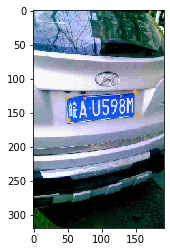

In [6]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = Path(img_dir)
        self.trans = transforms.ToTensor()
        data_len = len(self.anns)
        
        self.point_data = []
        self.imgs = []
        for i, ann in enumerate(self.anns):
            print('\r %4d / %4d' % (i+1, data_len), end='')
            img = Image.open(self.img_dir / ann['name'])
            w, h = img.size
            img_ = img.resize((192,320))
            del img
            img = self.trans(img_)
            del img_
            self.imgs.append(img)
            
            a = torch.FloatTensor(8)
            for i, field in enumerate(FIELDS):
                if field[-1] == 'x':
                    a[i] = ann[field] / w
                else:
                    a[i] = ann[field] / h
            self.point_data.append(a)
        print()

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        img = self.imgs[idx]
        kpt = self.point_data[idx]
        return img, kpt

# Do some checking and visualization
data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
print(len(data))    # should be 3000
# print(data.anns)
img, kpt = data[-1] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

In [7]:
del img
del kpt
del vis

## Network

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((4, 4)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
        )
        self.regression = nn.Sequential(
            nn.Flatten(), nn.Linear(480, 32), nn.ReLU(), nn.Linear(32, 8), nn.Sigmoid()
        )

    def forward(self, img_b):
        xa = self.features(img_b)
        res = self.regression(xa)
        return res


# Do some checking
loader = DataLoader(data, batch_size=10) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
device = 'cuda'     # the computing device, 'cuda' or 'cpu'
model = Net().to(device) # instantiate network and move it to device
criterion = nn.L1Loss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([10, 3, 320, 192])
torch.Size([10, 8])
tensor(0.1244, device='cuda:0', grad_fn=<L1LossBackward>)


In [9]:
del model
del criterion
del img_b
del kpt_b
del pred_b
del loss
del data

torch.cuda.empty_cache()
gc.collect()

2507

## Training

In [10]:
class Trainer:
    def __init__(self, log_dir):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR / 'train.csv', ROOT_DIR / 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, 10, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, 10, shuffle=False)
        self.visul_loader = DataLoader(self.visul_set, 10, shuffle=False)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.max_epoch = 100

    def run(self):
        metrics = {'train_loss': [], 'valid_loss': []}

        for self.epoch in range(self.max_epoch): 
            train_loss = self.train() 
            valid_loss = self.valid() 
            self.visul()             

            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)

        # Save the parameters(weights) of the model to disk
        torch.save(self.model.state_dict(), self.log_dir / 'model.pt')

        # Plot the loss curve against epoch
        plt.figure(1)
        plt.plot(list(range(self.max_epoch)), metrics['train_loss'], list(range(self.max_epoch)), metrics['valid_loss'])
        plt.legend(['train loss', 'valid loss'])
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.savefig(self.log_dir / 'metrics.png')

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_list = []
        for img, points in iter(self.train_loader):
            img = img.to(self.device)
            points = points.to(self.device)
            
            self.optimizer.zero_grad()
            pred_points = self.model(img)
            loss = self.criterion(pred_points, points)
            loss.backward()
            self.optimizer.step()
            
            loss_list.append(loss.detach().item())
            
        return sum(loss_list) / len(loss_list)

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_list = []
        for img, points in iter(self.valid_loader):
            img = img.to(self.device)
            points = points.to(self.device)
            
            pred_points = self.model(img)
            loss = self.criterion(pred_points, points)
            
            loss_list.append(loss.detach().item())
            
        return sum(loss_list) / len(loss_list)

    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1

log_dir = Path('./runs/') / f'{datetime.now():%b_%d_%H_%M_%S}'
log_dir.mkdir(parents=True)
t = Trainer(log_dir)

 3000 / 3000


Epoch 000:
train loss: 0.030089125929710765
valid loss: 0.018669843239088855
Epoch 001:
train loss: 0.0166650171779717
valid loss: 0.017463583126664163
Epoch 002:
train loss: 0.014246697227160135
valid loss: 0.015712467953562737
Epoch 003:
train loss: 0.012366786835870395
valid loss: 0.010749862195613484
Epoch 004:
train loss: 0.011437039164593443
valid loss: 0.01046404082638522
Epoch 005:
train loss: 0.01103024094675978
valid loss: 0.01151823333154122
Epoch 006:
train loss: 0.009937060843609895
valid loss: 0.010095813730731606
Epoch 007:
train loss: 0.009905280908181642
valid loss: 0.010314101190306246
Epoch 008:
train loss: 0.009856446459889413
valid loss: 0.010315004588725666
Epoch 009:
train loss: 0.009672040274987618
valid loss: 0.009878790751099587
Epoch 010:
train loss: 0.009017355258887012
valid loss: 0.010328571692419549
Epoch 011:
train loss: 0.009333676386935016
valid loss: 0.009048275106276074
Epoch 012:
train loss: 0.008928527230940139
valid loss: 0.009834164528486629
Epoc

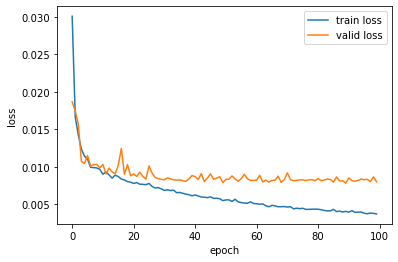

In [11]:
t.run()

## Testing

In [12]:
del t

gc.collect()

2753

In [13]:
device = 'cuda'
model = Net().to(device)
model.load_state_dict(torch.load(log_dir / 'model.pt'))
model.eval()
trans2 = transforms.ToTensor()
# Do testing
test_img_dir = ROOT_DIR / 'test_images'
submission = pd.read_csv(ROOT_DIR / 'sample.csv').to_dict('records')

test_out_dir = ROOT_DIR / 'test_image_results'
if not test_out_dir.exists():
    test_out_dir.mkdir(parents=True)

lenn = len(submission)
for i, item in enumerate(submission):
    print('\r %4d / %4d' % (i+1, lenn), end='')
    im = Image.open(test_img_dir / item['name'])
    w, h = im.size
    im_ = im.resize((192,320))
    im_ = trans2(im_)
    D, H, W = im_.size()
    im__ = im_.view(1, D, H, W)
    im__ = im__.to(device)
    pred = model(im__).cpu().detach()
    vis = draw_kpts(im, pred, c='red')
    pred = pred.numpy().reshape(-1)
    vis.save(test_out_dir / item['name'])
    for i, field in enumerate(FIELDS):
        if field[-1] == 'x':
            item[field] = pred[i] * w
        else:
            item[field] = pred[i] * h

print()
a = pd.DataFrame.from_dict(submission)
a.to_csv(ROOT_DIR / 'test.csv', index=False)

 3000 / 3000


runs\Dec_16_13_42_12\004\000.jpg


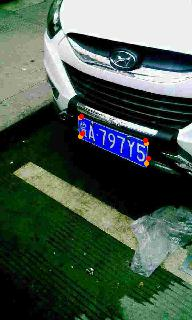

runs\Dec_16_13_42_12\004\001.jpg


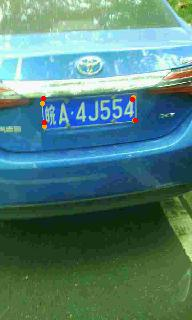

runs\Dec_16_13_42_12\004\002.jpg


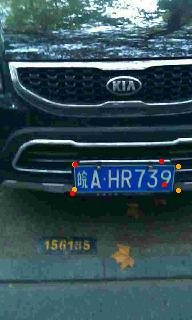

runs\Dec_16_13_42_12\004\003.jpg


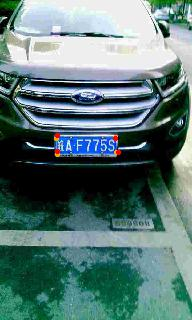

runs\Dec_16_13_42_12\004\004.jpg


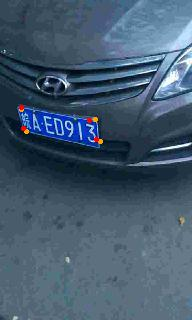

runs\Dec_16_13_42_12\004\005.jpg


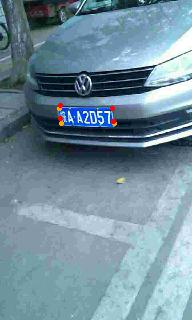

runs\Dec_16_13_42_12\004\006.jpg


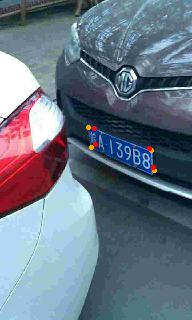

runs\Dec_16_13_42_12\004\007.jpg


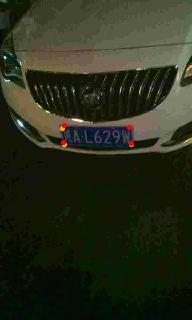

runs\Dec_16_13_42_12\004\008.jpg


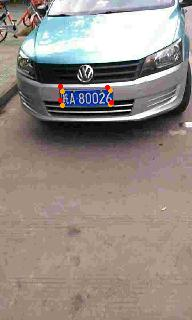

runs\Dec_16_13_42_12\004\009.jpg


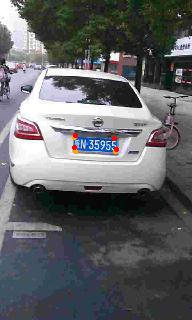

runs\Dec_16_13_42_12\004\010.jpg


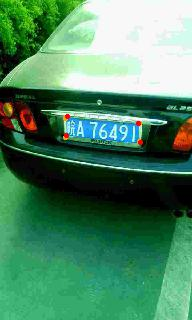

runs\Dec_16_13_42_12\004\011.jpg


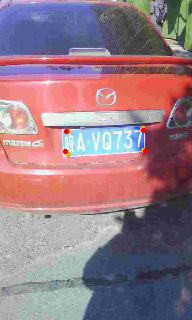

runs\Dec_16_13_42_12\004\012.jpg


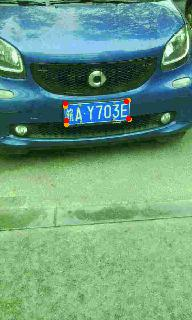

runs\Dec_16_13_42_12\004\013.jpg


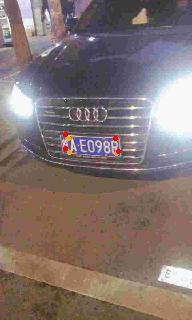

runs\Dec_16_13_42_12\004\014.jpg


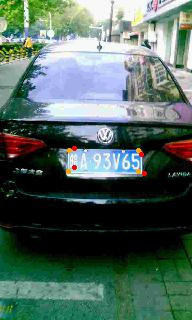

runs\Dec_16_13_42_12\004\015.jpg


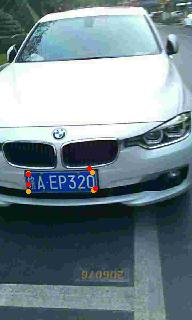

runs\Dec_16_13_42_12\004\016.jpg


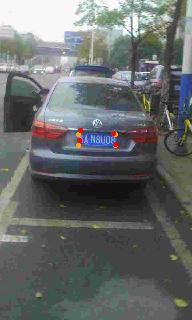

runs\Dec_16_13_42_12\004\017.jpg


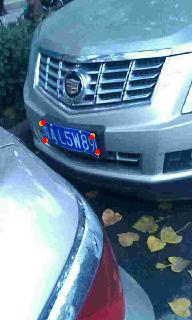

runs\Dec_16_13_42_12\004\018.jpg


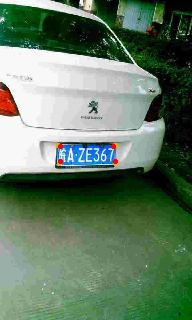

runs\Dec_16_13_42_12\004\019.jpg


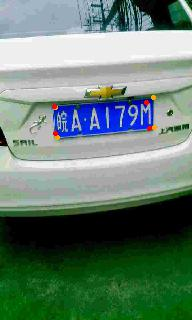

runs\Dec_16_13_42_12\004\020.jpg


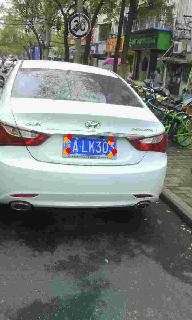

runs\Dec_16_13_42_12\004\021.jpg


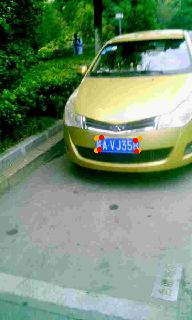

runs\Dec_16_13_42_12\004\022.jpg


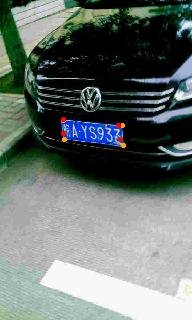

runs\Dec_16_13_42_12\004\023.jpg


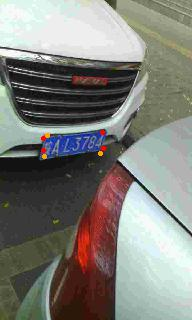

runs\Dec_16_13_42_12\004\024.jpg


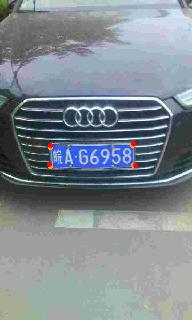

runs\Dec_16_13_42_12\004\025.jpg


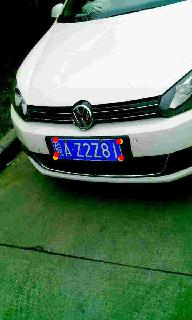

runs\Dec_16_13_42_12\004\026.jpg


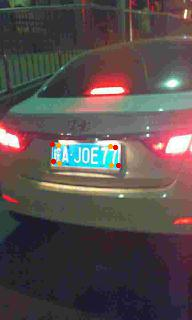

runs\Dec_16_13_42_12\004\027.jpg


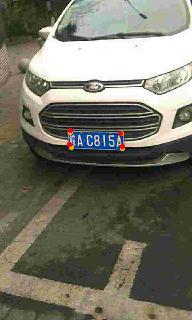

runs\Dec_16_13_42_12\004\028.jpg


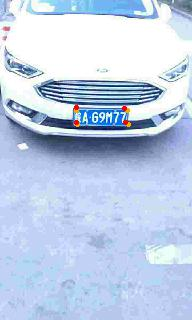

runs\Dec_16_13_42_12\004\029.jpg


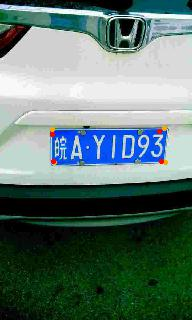

runs\Dec_16_13_42_12\004\030.jpg


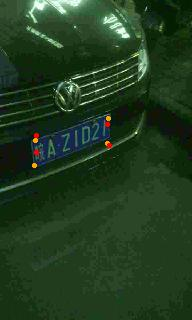

runs\Dec_16_13_42_12\004\031.jpg


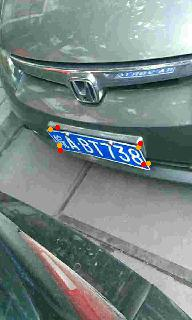

runs\Dec_16_13_42_12\004\032.jpg


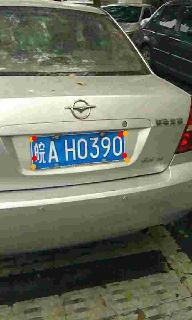

runs\Dec_16_13_42_12\004\033.jpg


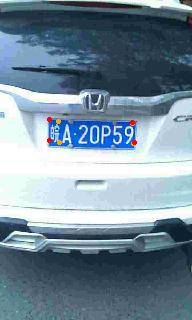

runs\Dec_16_13_42_12\004\034.jpg


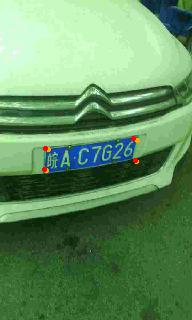

runs\Dec_16_13_42_12\004\035.jpg


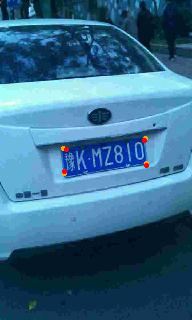

runs\Dec_16_13_42_12\004\036.jpg


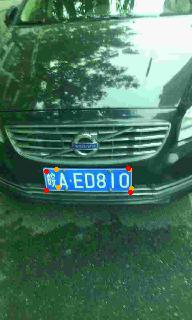

runs\Dec_16_13_42_12\004\037.jpg


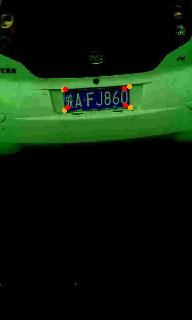

runs\Dec_16_13_42_12\004\038.jpg


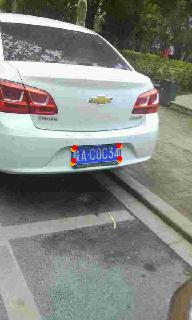

runs\Dec_16_13_42_12\004\039.jpg


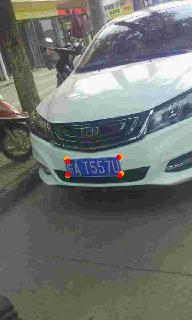

runs\Dec_16_13_42_12\004\040.jpg


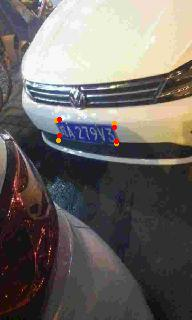

runs\Dec_16_13_42_12\004\041.jpg


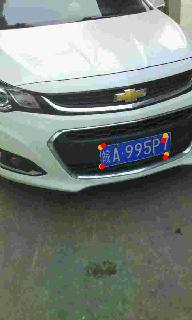

runs\Dec_16_13_42_12\004\042.jpg


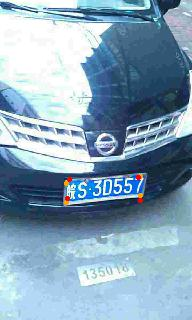

runs\Dec_16_13_42_12\004\043.jpg


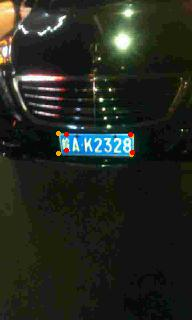

runs\Dec_16_13_42_12\004\044.jpg


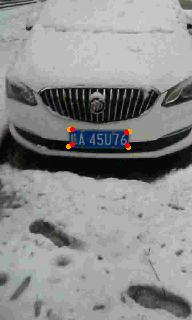

runs\Dec_16_13_42_12\004\045.jpg


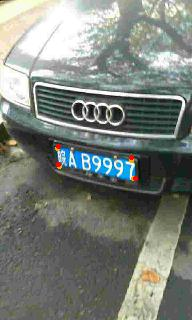

runs\Dec_16_13_42_12\004\046.jpg


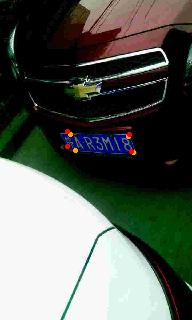

runs\Dec_16_13_42_12\004\047.jpg


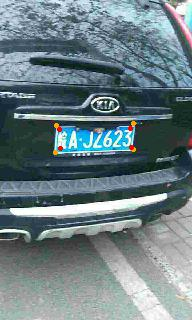

runs\Dec_16_13_42_12\004\048.jpg


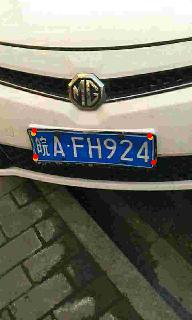

runs\Dec_16_13_42_12\004\049.jpg


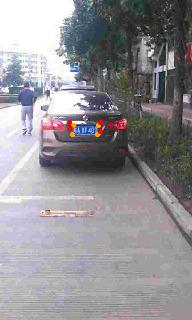

In [14]:
for index in range(50):
    print(str(log_dir / '004' / f'{index:03d}.jpg'))
    display.display(display.Image(str(log_dir / '004' / f'{index:03d}.jpg')))

runs\Dec_16_13_42_12\099\000.jpg


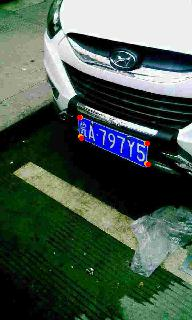

runs\Dec_16_13_42_12\099\001.jpg


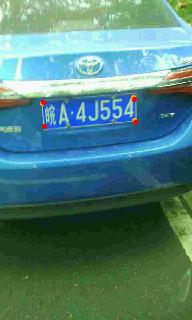

runs\Dec_16_13_42_12\099\002.jpg


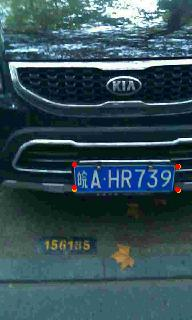

runs\Dec_16_13_42_12\099\003.jpg


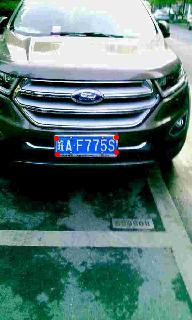

runs\Dec_16_13_42_12\099\004.jpg


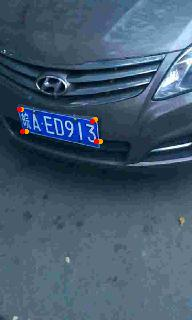

runs\Dec_16_13_42_12\099\005.jpg


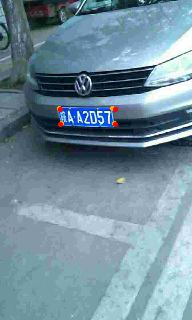

runs\Dec_16_13_42_12\099\006.jpg


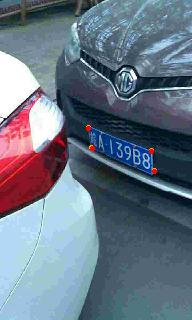

runs\Dec_16_13_42_12\099\007.jpg


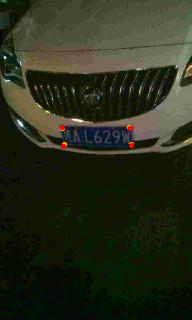

runs\Dec_16_13_42_12\099\008.jpg


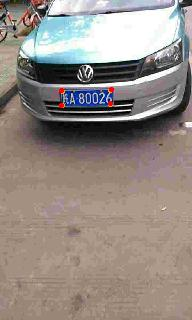

runs\Dec_16_13_42_12\099\009.jpg


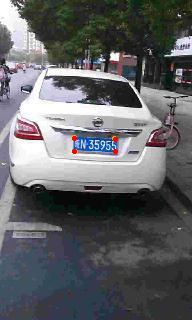

runs\Dec_16_13_42_12\099\010.jpg


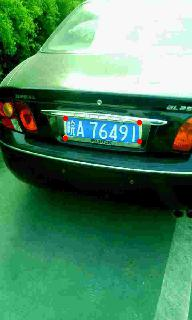

runs\Dec_16_13_42_12\099\011.jpg


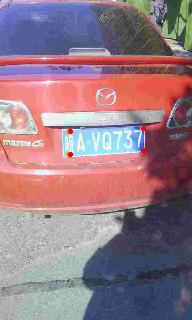

runs\Dec_16_13_42_12\099\012.jpg


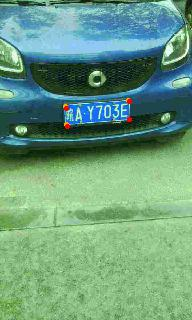

runs\Dec_16_13_42_12\099\013.jpg


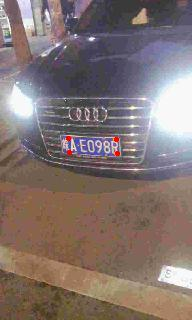

runs\Dec_16_13_42_12\099\014.jpg


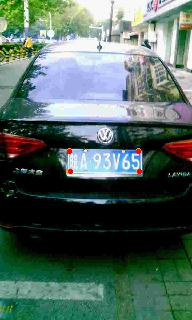

runs\Dec_16_13_42_12\099\015.jpg


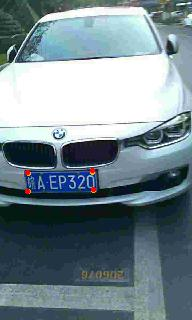

runs\Dec_16_13_42_12\099\016.jpg


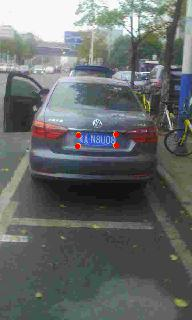

runs\Dec_16_13_42_12\099\017.jpg


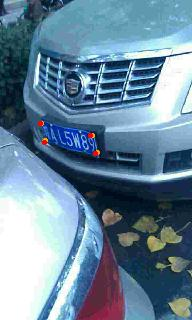

runs\Dec_16_13_42_12\099\018.jpg


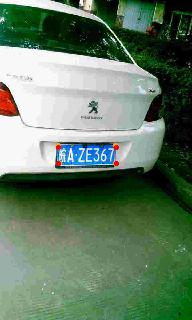

runs\Dec_16_13_42_12\099\019.jpg


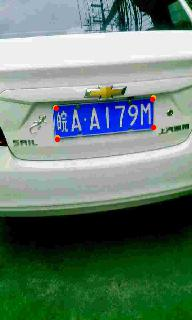

runs\Dec_16_13_42_12\099\020.jpg


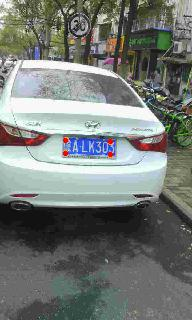

runs\Dec_16_13_42_12\099\021.jpg


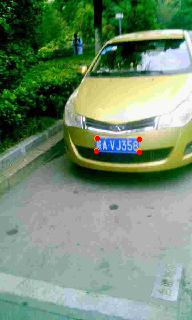

runs\Dec_16_13_42_12\099\022.jpg


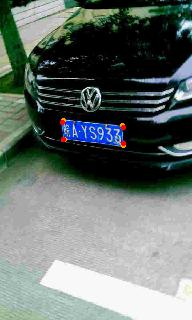

runs\Dec_16_13_42_12\099\023.jpg


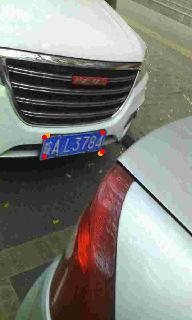

runs\Dec_16_13_42_12\099\024.jpg


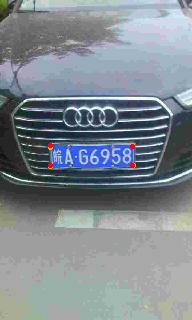

runs\Dec_16_13_42_12\099\025.jpg


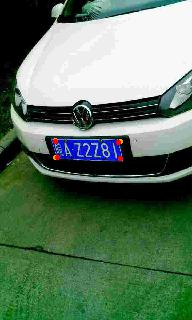

runs\Dec_16_13_42_12\099\026.jpg


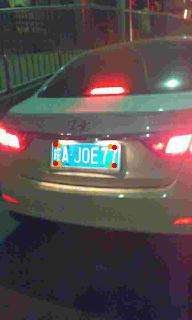

runs\Dec_16_13_42_12\099\027.jpg


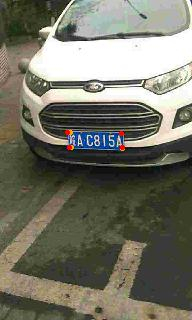

runs\Dec_16_13_42_12\099\028.jpg


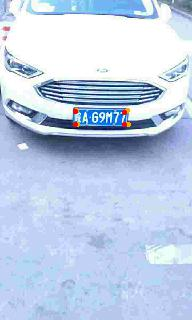

runs\Dec_16_13_42_12\099\029.jpg


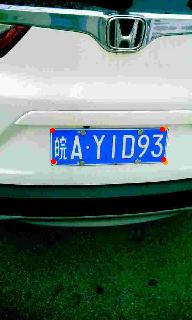

runs\Dec_16_13_42_12\099\030.jpg


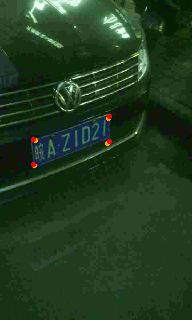

runs\Dec_16_13_42_12\099\031.jpg


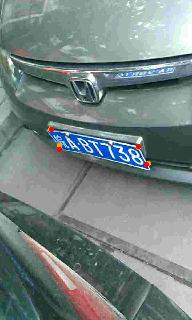

runs\Dec_16_13_42_12\099\032.jpg


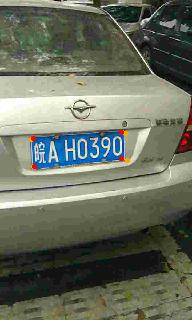

runs\Dec_16_13_42_12\099\033.jpg


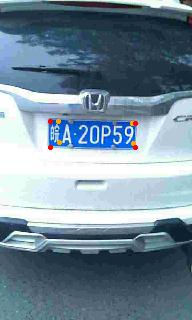

runs\Dec_16_13_42_12\099\034.jpg


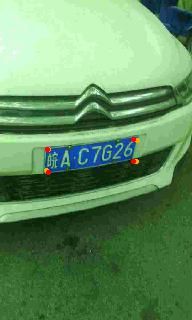

runs\Dec_16_13_42_12\099\035.jpg


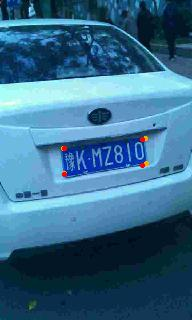

runs\Dec_16_13_42_12\099\036.jpg


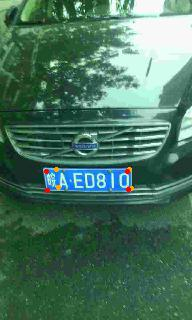

runs\Dec_16_13_42_12\099\037.jpg


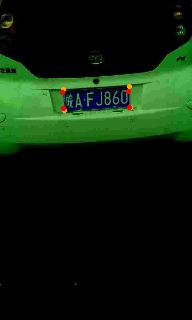

runs\Dec_16_13_42_12\099\038.jpg


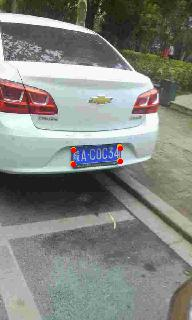

runs\Dec_16_13_42_12\099\039.jpg


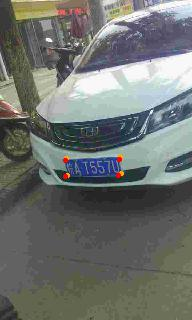

runs\Dec_16_13_42_12\099\040.jpg


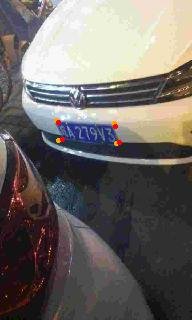

runs\Dec_16_13_42_12\099\041.jpg


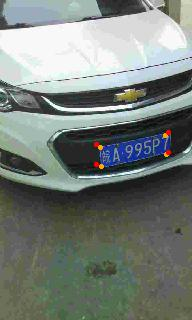

runs\Dec_16_13_42_12\099\042.jpg


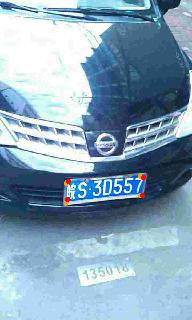

runs\Dec_16_13_42_12\099\043.jpg


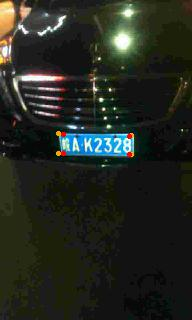

runs\Dec_16_13_42_12\099\044.jpg


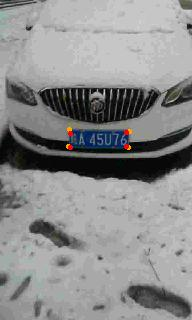

runs\Dec_16_13_42_12\099\045.jpg


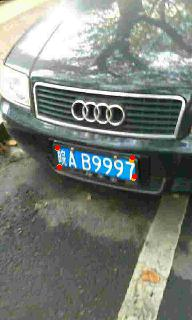

runs\Dec_16_13_42_12\099\046.jpg


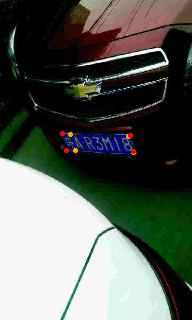

runs\Dec_16_13_42_12\099\047.jpg


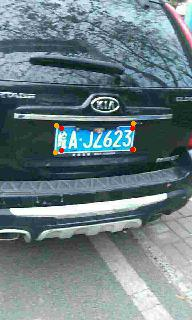

runs\Dec_16_13_42_12\099\048.jpg


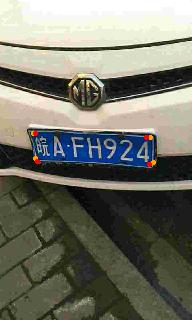

runs\Dec_16_13_42_12\099\049.jpg


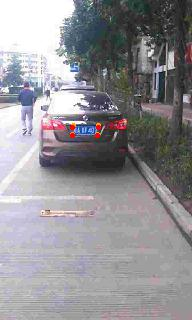

In [15]:
for index in range(50):
    print(str(log_dir / '099' / f'{index:03d}.jpg'))
    display.display(display.Image(str(log_dir / '099' / f'{index:03d}.jpg')))

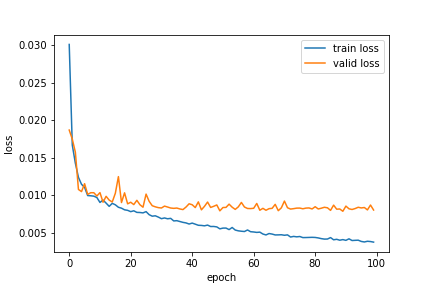

In [16]:
display.Image(str(log_dir / 'metrics.png')) # Loss

In [17]:
b = Browser()

files = {'file': open(ROOT_DIR / 'test.csv', 'rb')}

r, s = b.post('http://140.114.76.113:5000/cs6550', files=files)
print(s)

{"rmse":13.199}

